In [4]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [5]:
#@save
def download(name, cache_dir=os.path.join('..', 'data')):
    """download a file from DATA_HUB, return local file name"""
    assert name in DATA_HUB, f"{name} didn't exist in {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname # hit cache
    print(f'downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [6]:
#@save
def download_extract(name, folder=None):
    """download and unzip zip/tar file"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'only zip/tar file can be unzipped'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

#@save
def download_all():
    """download all files in DATA_HUB"""
    for name in DATA_HUB:
        download(name)

In [7]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

### download the data

In [8]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce'
)
DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90'
)

In [9]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [10]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [11]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [12]:
# delete id(first column) feature and label(last column)
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

### data preprocessing

In [13]:
# if we cannot get test data, we can calculate mean and std using training data
numeric_features = all_features.dtypes[all_features.dtypes!='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std())
)
# after normalize the data, all of the means become 0
# at this time, fill the missing data with 0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [14]:
# "dummy_na=True" treats "na"(missing data) as valid feature
all_features = pd.get_dummies(all_features, dummy_na=True)

all_features.shape

(2919, 331)

In [15]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32
)

### training

we try to fit a linear model with MSE loss

In [84]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net
get_net()

Sequential(
  (0): Linear(in_features=331, out_features=1, bias=True)
)

$$
\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log{y_i}-\log{\hat{y}_i})^2}
$$

In [85]:
def log_rmse(net, features, labels):
    # to further stabilize the values when taking logarithms
    # set values less than 1 to 1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item()

In [86]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # adam optimizer
    optimizer = torch.optim.Adam(
        net.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

### k-fold cross-validation

In [87]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [88]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'fold: {i + 1}, training log rmse: {float(train_ls[-1]):f}, '
              f'test log rmse: {float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

### model selection

fold: 1, training log rmse: 0.126205, test log rmse: 0.153201
fold: 2, training log rmse: 0.121032, test log rmse: 0.151955
fold: 3, training log rmse: 0.122222, test log rmse: 0.150926
fold: 4, training log rmse: 0.127031, test log rmse: 0.137573
fold: 5, training log rmse: 0.117852, test log rmse: 0.162062
5-fold cross-validation: average training log rmse: 0.122868, average test log rmse: 0.151143


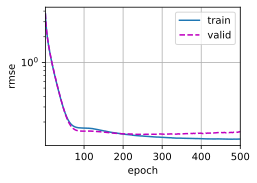

In [92]:
k, num_epochs, lr, weight_decay, batch_size = 5, 500, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, 
                          lr, weight_decay, batch_size)
print(f'{k}-fold cross-validation: average training log rmse: {float(train_l):f}, '
      f'average test log rmse: {float(valid_l):f}')

### submit to Kaggle

In [94]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'training log rmse: {float(train_ls[-1]):f}')
    # apply the network to test set
    preds = net(test_features).detach().numpy()
    # reformat it for export to Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

training log rmse: 0.124158


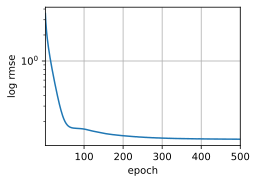

In [95]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)